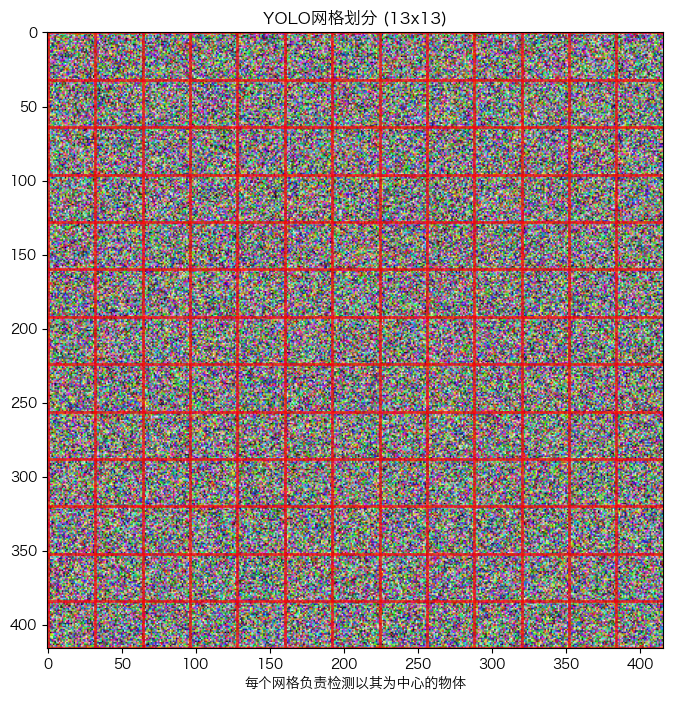

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import cv2
from PIL import Image

# 全局中文字体设置（macOS/常见平台通用）
import matplotlib.pyplot as plt
from matplotlib import font_manager, rcParams

available_fonts = {f.name for f in font_manager.fontManager.ttflist}
preferred_fonts = [
    "PingFang SC", "Hiragino Sans GB", "Heiti SC", "SimHei",
    "Microsoft YaHei", "Noto Sans CJK SC", "Arial Unicode MS"
]
for name in preferred_fonts:
    if name in available_fonts:
        rcParams["font.sans-serif"] = [name]
        break

rcParams["axes.unicode_minus"] = False  # 修复负号显示为方块的问题

# 模拟一个简单的图像网格化过程
def visualize_grid(image_size=416, grid_size=13):
    """可视化YOLO的网格划分"""
    fig, ax = plt.subplots(1, 1, figsize=(8, 8))
    
    # 创建一个示例图像
    image = np.random.rand(image_size, image_size, 3)
    
    # 绘制网格线
    step = image_size // grid_size
    for i in range(0, image_size + 1, step):
        ax.axhline(y=i, color='red', linewidth=2, alpha=0.7)
        ax.axvline(x=i, color='red', linewidth=2, alpha=0.7)
    
    ax.imshow(image)
    ax.set_title(f'YOLO网格划分 ({grid_size}x{grid_size})')
    ax.set_xlabel('每个网格负责检测以其为中心的物体')
    plt.show()

# 可视化网格
visualize_grid()

In [6]:
class YOLOPrediction:
    """理解YOLO的预测输出格式"""
    
    def __init__(self, grid_size=7, num_classes=20, num_boxes=2):
        self.S = grid_size      # 网格大小 7x7
        self.B = num_boxes      # 每个网格预测的边界框数量
        self.C = num_classes    # 类别数量
        
    def explain_output_tensor(self):
        """解释YOLO输出张量的含义"""
        print("YOLO输出张量形状解释：")
        print(f"输出形状: [{self.S}, {self.S}, {self.B * 5 + self.C}]")
        print(f"具体数值: [7, 7, {self.B * 5 + self.C}]")
        print("\n每个网格的预测包含：")
        
        for b in range(self.B):
            print(f"边界框{b+1}: [x, y, w, h, confidence] = 5个值")
        
        print(f"类别概率: [{self.C}个类别的概率]")
        print(f"\n总计每个网格: {self.B} × 5 + {self.C} = {self.B * 5 + self.C}个预测值")

# 创建预测解释器
predictor = YOLOPrediction()
predictor.explain_output_tensor()

YOLO输出张量形状解释：
输出形状: [7, 7, 30]
具体数值: [7, 7, 30]

每个网格的预测包含：
边界框1: [x, y, w, h, confidence] = 5个值
边界框2: [x, y, w, h, confidence] = 5个值
类别概率: [20个类别的概率]

总计每个网格: 2 × 5 + 20 = 30个预测值


In [ ]:
class SimpleYOLO(nn.Module):
    """简化版YOLO网络，便于理解核心概念"""
    
    def __init__(self, grid_size=7, num_boxes=2, num_classes=20):
        super(SimpleYOLO, self).__init__()
        
        self.S = grid_size
        self.B = num_boxes  
        self.C = num_classes
        
        # 特征提取部分（类似ResNet的思想）
        self.features = nn.Sequential(
            # 第一组卷积层
            nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            # 第二组卷积层
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            # 第三组卷积层
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            # 第四组卷积层
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        
        # 检测头部分
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d((self.S, self.S)),  # 确保输出是SxS
            nn.Conv2d(512, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, self.B * 5 + self.C, kernel_size=1),  # 最终预测层
        )
        
    def forward(self, x):
        # 特征提取
        features = self.features(x)
        print(f"特征提取后的形状: {features.shape}")
        
        # 检测预测
        output = self.classifier(features)
        print(f"最终输出形状: {output.shape}")
        
        # 重塑为 [batch_size, S, S, B*5+C]
        batch_size = output.size(0)
        output = output.permute(0, 2, 3, 1)  # [B, S, S, B*5+C]
        
        return output

# 创建模型并测试
model = SimpleYOLO(grid_size=7, num_boxes=2, num_classes=20)
dummy_input = torch.randn(1, 3, 448, 448)  # YOLO典型输入尺寸

print("YOLO网络结构测试：")
output = model(dummy_input)
print(f"最终输出形状: {output.shape}")
print(f"解释: [batch_size={output.shape[0]}, grid_height={output.shape[1]}, grid_width={output.shape[2]}, predictions={output.shape[3]}]")

In [ ]:
def parse_yolo_output(predictions, grid_size=7, num_boxes=2, num_classes=20):
    """解析YOLO的原始预测输出"""
    
    batch_size, S, S, _ = predictions.shape
    
    # 分离不同类型的预测
    # 边界框预测：前B*5个值
    box_predictions = predictions[:, :, :, :num_boxes*5]
    box_predictions = box_predictions.view(batch_size, S, S, num_boxes, 5)
    
    # 类别预测：后C个值
    class_predictions = predictions[:, :, :, num_boxes*5:]
    
    print("YOLO预测解析：")
    print(f"边界框预测形状: {box_predictions.shape}")
    print(f"类别预测形状: {class_predictions.shape}")
    
    # 解释每个部分
    print("\n边界框预测包含：")
    print("- x, y: 边界框中心相对于网格的偏移 (0-1)")
    print("- w, h: 边界框宽高相对于整图的比例 (0-1)")
    print("- confidence: 该框包含物体的置信度 (0-1)")
    
    print("\n类别预测包含：")
    print(f"- {num_classes}个类别的概率分布")
    
    return box_predictions, class_predictions

# 使用前面的模型输出
box_pred, class_pred = parse_yolo_output(output)

In [ ]:
class YOLOLoss(nn.Module):
    """YOLO损失函数的详细实现和解释"""
    
    def __init__(self, S=7, B=2, C=20, lambda_coord=5, lambda_noobj=0.5):
        super(YOLOLoss, self).__init__()
        self.S = S                    # 网格大小
        self.B = B                    # 每网格边界框数
        self.C = C                    # 类别数
        self.lambda_coord = lambda_coord    # 坐标损失权重
        self.lambda_noobj = lambda_noobj    # 无物体损失权重
        
    def forward(self, predictions, targets):
        """
        predictions: [batch_size, S, S, B*5+C]
        targets: [batch_size, S, S, B*5+C] (ground truth)
        """
        
        batch_size = predictions.size(0)
        
        # 分离预测和真值
        pred_boxes = predictions[:, :, :, :self.B*5].view(batch_size, self.S, self.S, self.B, 5)
        pred_classes = predictions[:, :, :, self.B*5:]
        
        target_boxes = targets[:, :, :, :self.B*5].view(batch_size, self.S, self.S, self.B, 5)
        target_classes = targets[:, :, :, self.B*5:]
        
        # 1. 坐标损失 (只对有物体的格子计算)
        coord_mask = target_boxes[:, :, :, :, 4] > 0  # confidence > 0表示有物体
        
        # 提取坐标 (x, y, w, h)
        pred_xy = pred_boxes[:, :, :, :, :2]
        pred_wh = pred_boxes[:, :, :, :, 2:4]
        target_xy = target_boxes[:, :, :, :, :2]
        target_wh = target_boxes[:, :, :, :, 2:4]
        
        # 坐标损失计算
        coord_loss_xy = F.mse_loss(pred_xy[coord_mask], target_xy[coord_mask], reduction='sum')
        coord_loss_wh = F.mse_loss(torch.sqrt(pred_wh[coord_mask]), torch.sqrt(target_wh[coord_mask]), reduction='sum')
        coord_loss = self.lambda_coord * (coord_loss_xy + coord_loss_wh)
        
        # 2. 置信度损失
        pred_conf = pred_boxes[:, :, :, :, 4]
        target_conf = target_boxes[:, :, :, :, 4]
        
        # 有物体的置信度损失
        obj_loss = F.mse_loss(pred_conf[coord_mask], target_conf[coord_mask], reduction='sum')
        
        # 无物体的置信度损失
        noobj_mask = target_boxes[:, :, :, :, 4] == 0
        noobj_loss = self.lambda_noobj * F.mse_loss(pred_conf[noobj_mask], target_conf[noobj_mask], reduction='sum')
        
        # 3. 分类损失 (只对有物体的格子计算)
        obj_mask_class = (target_boxes[:, :, :, 0, 4] > 0).unsqueeze(-1).expand_as(target_classes)
        class_loss = F.mse_loss(pred_classes[obj_mask_class], target_classes[obj_mask_class], reduction='sum')
        
        # 总损失
        total_loss = coord_loss + obj_loss + noobj_loss + class_loss
        
        # 返回详细的损失信息
        return {
            'total_loss': total_loss,
            'coord_loss': coord_loss,
            'obj_loss': obj_loss, 
            'noobj_loss': noobj_loss,
            'class_loss': class_loss
        }

# 演示损失函数的使用
def demo_loss_function():
    """演示YOLO损失函数的计算过程"""
    
    criterion = YOLOLoss(S=7, B=2, C=20)
    
    # 创建模拟的预测和真值
    batch_size = 2
    predictions = torch.randn(batch_size, 7, 7, 30)  # 随机预测
    targets = torch.zeros(batch_size, 7, 7, 30)      # 空白真值
    
    # 在targets中设置一个真实物体
    targets[0, 3, 3, 4] = 0.9    # 第一个边界框的confidence
    targets[0, 3, 3, 0:2] = torch.tensor([0.5, 0.5])  # 中心点
    targets[0, 3, 3, 2:4] = torch.tensor([0.3, 0.4])  # 宽高
    targets[0, 3, 3, 10] = 1.0   # 第一个类别为正样本
    
    # 计算损失
    loss_dict = criterion(predictions, targets)
    
    print("YOLO损失函数详解：")
    print("-" * 50)
    for key, value in loss_dict.items():
        print(f"{key}: {value.item():.4f}")
    
    print("\n损失函数组成解释：")
    print("1. coord_loss: 边界框坐标预测损失（加权重λ_coord=5）")
    print("2. obj_loss: 有物体格子的置信度损失")
    print("3. noobj_loss: 无物体格子的置信度损失（加权重λ_noobj=0.5）")
    print("4. class_loss: 类别分类损失")
    print("5. total_loss: 所有损失的总和")

demo_loss_function()

In [ ]:
def convert_predictions_to_boxes(predictions, grid_size=7, img_size=448):
    """将YOLO网络预测转换为实际的边界框坐标"""
    
    batch_size, S, S, _ = predictions.shape
    boxes = []
    
    for b in range(batch_size):
        batch_boxes = []
        
        for i in range(S):
            for j in range(S):
                # 获取当前网格的预测
                grid_pred = predictions[b, i, j, :]
                
                # 解析边界框（假设只取第一个边界框）
                x_offset = grid_pred[0]  # 相对网格的偏移
                y_offset = grid_pred[1]
                w = grid_pred[2]         # 相对整图的宽度
                h = grid_pred[3]         # 相对整图的高度
                confidence = torch.sigmoid(grid_pred[4])
                
                # 转换为实际坐标
                x_center = (j + x_offset) * (img_size / S)
                y_center = (i + y_offset) * (img_size / S)
                width = w * img_size
                height = h * img_size
                
                # 转换为左上角和右下角坐标
                x1 = x_center - width / 2
                y1 = y_center - height / 2
                x2 = x_center + width / 2
                y2 = y_center + height / 2
                
                # 获取类别概率
                class_probs = torch.softmax(grid_pred[10:], dim=0)  # 假设从第10个开始是类别
                max_prob, class_id = torch.max(class_probs, dim=0)
                
                # 最终得分
                score = confidence * max_prob
                
                if score > 0.1:  # 置信度阈值
                    batch_boxes.append({
                        'bbox': [x1.item(), y1.item(), x2.item(), y2.item()],
                        'score': score.item(),
                        'class_id': class_id.item(),
                        'grid_pos': (i, j)
                    })
        
        boxes.append(batch_boxes)
    
    return boxes

def visualize_predictions(boxes, img_size=448, grid_size=7):
    """可视化预测结果"""
    
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    
    # 创建示例图像
    image = np.ones((img_size, img_size, 3)) * 0.9
    
    # 绘制网格
    step = img_size // grid_size
    for i in range(0, img_size + 1, step):
        ax.axhline(y=i, color='lightgray', linewidth=1, alpha=0.5)
        ax.axvline(x=i, color='lightgray', linewidth=1, alpha=0.5)
    
    # 绘制预测的边界框
    for box in boxes[0]:  # 只显示第一个batch
        x1, y1, x2, y2 = box['bbox']
        width = x2 - x1
        height = y2 - y1
        
        # 绘制边界框
        rect = plt.Rectangle((x1, y1), width, height, 
                           fill=False, color='red', linewidth=3)
        ax.add_patch(rect)
        
        # 添加标签
        ax.text(x1, y1-5, f"Class {box['class_id']}: {box['score']:.2f}", 
                color='red', fontsize=10, fontweight='bold')
        
        # 标记对应的网格
        grid_i, grid_j = box['grid_pos']
        grid_x = grid_j * step + step//2
        grid_y = grid_i * step + step//2
        ax.plot(grid_x, grid_y, 'ro', markersize=8)
    
    ax.imshow(image)
    ax.set_title('YOLO预测结果可视化')
    ax.set_xlim(0, img_size)
    ax.set_ylim(img_size, 0)  # 翻转Y轴
    plt.show()

# 演示坐标转换
print("演示坐标转换过程：")
dummy_predictions = torch.randn(1, 7, 7, 30)
# 设置一些合理的值来模拟检测结果
dummy_predictions[0, 2, 3, 4] = 2.0  # 高置信度
dummy_predictions[0, 2, 3, 15] = 3.0  # 高类别概率

converted_boxes = convert_predictions_to_boxes(dummy_predictions)
print(f"转换后的边界框数量: {len(converted_boxes[0])}")

if len(converted_boxes[0]) > 0:
    print("示例检测结果:")
    for i, box in enumerate(converted_boxes[0]):
        print(f"  框{i+1}: 位置{box['bbox']}, 得分{box['score']:.3f}, 类别{box['class_id']}")

In [ ]:
def compute_iou(box1, box2):
    """计算两个边界框的IoU"""
    
    # 获取交集区域的坐标
    x1 = max(box1[0], box2[0])
    y1 = max(box1[1], box2[1])
    x2 = min(box1[2], box2[2])
    y2 = min(box1[3], box2[3])
    
    # 计算交集面积
    if x2 <= x1 or y2 <= y1:
        return 0.0
    
    intersection = (x2 - x1) * (y2 - y1)
    
    # 计算两个框的面积
    area1 = (box1[2] - box1[0]) * (box1[3] - box1[1])
    area2 = (box2[2] - box2[0]) * (box2[3] - box2[1])
    
    # 计算并集面积
    union = area1 + area2 - intersection
    
    return intersection / union

def non_max_suppression(boxes, iou_threshold=0.5):
    """非极大值抑制算法"""
    
    if len(boxes) == 0:
        return []
    
    # 按得分排序
    boxes = sorted(boxes, key=lambda x: x['score'], reverse=True)
    
    keep = []
    indices = list(range(len(boxes)))
    
    print("NMS处理过程：")
    print("-" * 50)
    
    while indices:
        # 选择得分最高的框
        current_idx = indices[0]
        current_box = boxes[current_idx]
        keep.append(current_box)
        
        print(f"保留框: 得分{current_box['score']:.3f}, 位置{current_box['bbox']}")
        
        # 移除当前框
        indices = indices[1:]
        
        # 计算与其他框的IoU，移除重叠度高的框
        remaining_indices = []
        for idx in indices:
            iou = compute_iou(current_box['bbox'], boxes[idx]['bbox'])
            if iou <= iou_threshold:
                remaining_indices.append(idx)
            else:
                print(f"  移除框: IoU={iou:.3f} > {iou_threshold}, 得分{boxes[idx]['score']:.3f}")
        
        indices = remaining_indices
    
    print(f"\nNMS后保留{len(keep)}个检测框")
    return keep

# 演示NMS
def demo_nms():
    """演示NMS的工作过程"""
    
    # 创建一些重叠的检测框
    demo_boxes = [
        {'bbox': [100, 100, 200, 200], 'score': 0.9, 'class_id': 1},
        {'bbox': [110, 110, 210, 210], 'score': 0.8, 'class_id': 1},  # 与第一个重叠
        {'bbox': [300, 300, 400, 400], 'score': 0.7, 'class_id': 2},
        {'bbox': [105, 105, 195, 195], 'score': 0.6, 'class_id': 1},  # 与第一个重叠
        {'bbox': [350, 350, 450, 450], 'score': 0.5, 'class_id': 2},  # 与第三个重叠
    ]
    
    print("原始检测框：")
    for i, box in enumerate(demo_boxes):
        print(f"框{i+1}: {box}")
    
    print("\n" + "="*60)
    
    # 应用NMS
    filtered_boxes = non_max_suppression(demo_boxes, iou_threshold=0.3)
    
    print("\n最终结果：")
    for i, box in enumerate(filtered_boxes):
        print(f"框{i+1}: {box}")

demo_nms()

In [ ]:
class YOLODetector:
    """完整的YOLO检测器"""
    
    def __init__(self, model, grid_size=7, num_classes=20, confidence_threshold=0.1, nms_threshold=0.5):
        self.model = model
        self.grid_size = grid_size
        self.num_classes = num_classes
        self.confidence_threshold = confidence_threshold
        self.nms_threshold = nms_threshold
        
        # PASCAL VOC类别名称
        self.class_names = [
            'person', 'bird', 'cat', 'cow', 'dog', 'horse', 'sheep',
            'aeroplane', 'bicycle', 'boat', 'bus', 'car', 'motorbike', 'train',
            'bottle', 'chair', 'diningtable', 'pottedplant', 'sofa', 'tvmonitor'
        ]
    
    def detect(self, image):
        """完整的检测流程"""
        
        print("YOLO检测流程：")
        print("1. 图像预处理...")
        
        # 1. 预处理
        if isinstance(image, np.ndarray):
            image_tensor = torch.FloatTensor(image).permute(2, 0, 1).unsqueeze(0) / 255.0
        else:
            image_tensor = image
        
        print("2. 神经网络推理...")
        
        # 2. 网络推理
        self.model.eval()
        with torch.no_grad():
            predictions = self.model(image_tensor)
        
        print("3. 解析预测结果...")
        
        # 3. 解析预测
        boxes = self._parse_predictions(predictions, image_tensor.shape[-1])
        
        print("4. 非极大值抑制...")
        
        # 4. NMS
        final_boxes = []
        for class_id in range(self.num_classes):
            class_boxes = [box for box in boxes if box['class_id'] == class_id]
            if class_boxes:
                class_boxes = non_max_suppression(class_boxes, self.nms_threshold)
                final_boxes.extend(class_boxes)
        
        print(f"5. 检测完成，共找到{len(final_boxes)}个目标")
        
        return final_boxes
    
    def _parse_predictions(self, predictions, img_size):
        """解析网络预测结果"""
        
        batch_size, S, S, _ = predictions.shape
        boxes = []
        
        for i in range(S):
            for j in range(S):
                grid_pred = predictions[0, i, j, :]  # 取第一个batch
                
                # 解析两个边界框
                for b in range(2):  # 假设每个网格预测2个框
                    start_idx = b * 5
                    
                    x_offset = torch.sigmoid(grid_pred[start_idx])
                    y_offset = torch.sigmoid(grid_pred[start_idx + 1])
                    w = torch.sigmoid(grid_pred[start_idx + 2])
                    h = torch.sigmoid(grid_pred[start_idx + 3])
                    confidence = torch.sigmoid(grid_pred[start_idx + 4])
                    
                    # 坐标转换
                    x_center = (j + x_offset) * (img_size / S)
                    y_center = (i + y_offset) * (img_size / S)
                    width = w * img_size
                    height = h * img_size
                    
                    x1 = x_center - width / 2
                    y1 = y_center - height / 2
                    x2 = x_center + width / 2
                    y2 = y_center + height / 2
                    
                    # 类别概率
                    class_probs = torch.softmax(grid_pred[10:], dim=0)
                    max_prob, class_id = torch.max(class_probs, dim=0)
                    
                    score = confidence * max_prob
                    
                    if score > self.confidence_threshold:
                        boxes.append({
                            'bbox': [x1.item(), y1.item(), x2.item(), y2.item()],
                            'score': score.item(),
                            'class_id': class_id.item(),
                            'class_name': self.class_names[class_id.item()],
                            'confidence': confidence.item(),
                            'class_prob': max_prob.item()
                        })
        
        return boxes
    
    def visualize_results(self, image, boxes, save_path=None):
        """可视化检测结果"""
        
        if isinstance(image, torch.Tensor):
            image = image.squeeze().permute(1, 2, 0).numpy()
        
        fig, ax = plt.subplots(1, 1, figsize=(12, 12))
        ax.imshow(image)
        
        colors = plt.cm.Set3(np.linspace(0, 1, self.num_classes))
        
        for box in boxes:
            x1, y1, x2, y2 = box['bbox']
            width = x2 - x1
            height = y2 - y1
            
            # 获取类别颜色
            color = colors[box['class_id']]
            
            # 绘制边界框
            rect = plt.Rectangle((x1, y1), width, height, 
                               fill=False, color=color, linewidth=3)
            ax.add_patch(rect)
            
            # 添加标签
            label = f"{box['class_name']}: {box['score']:.2f}"
            ax.text(x1, y1-5, label, color=color, fontsize=12, 
                   fontweight='bold', bbox=dict(facecolor='white', alpha=0.7))
        
        ax.set_title(f'YOLO检测结果 (共{len(boxes)}个目标)')
        ax.axis('off')
        
        if save_path:
            plt.savefig(save_path, bbox_inches='tight', dpi=300)
        
        plt.show()

# 演示完整检测流程
def demo_complete_detection():
    """演示完整的YOLO检测流程"""
    
    print("=" * 60)
    print("完整YOLO检测演示")
    print("=" * 60)
    
    # 创建检测器
    model = SimpleYOLO(grid_size=7, num_boxes=2, num_classes=20)
    detector = YOLODetector(model, confidence_threshold=0.3, nms_threshold=0.5)
    
    # 创建模拟输入图像
    dummy_image = torch.randn(1, 3, 448, 448)
    
    # 进行检测
    results = detector.detect(dummy_image)
    
    print("\n检测结果详情：")
    print("-" * 40)
    for i, box in enumerate(results):
        print(f"目标{i+1}:")
        print(f"  类别: {box['class_name']}")
        print(f"  位置: ({box['bbox'][0]:.1f}, {box['bbox'][1]:.1f}, {box['bbox'][2]:.1f}, {box['bbox'][3]:.1f})")
        print(f"  置信度: {box['confidence']:.3f}")
        print(f"  类别概率: {box['class_prob']:.3f}")
        print(f"  最终得分: {box['score']:.3f}")
        print()

demo_complete_detection()

def analyze_yolo_advantages():
    """分析YOLO的优势"""
    
    advantages = {
        "速度优势": {
            "描述": "单次前向传播完成检测",
            "技术原理": "避免了两阶段检测器的候选区域生成步骤",
            "实际表现": "YOLOv5可达到100+ FPS",
            "应用场景": "实时视频处理、边缘计算设备"
        },
        
        "全局理解": {
            "描述": "能够看到完整的图像上下文",
            "技术原理": "网络接收整张图像作为输入",
            "实际表现": "减少背景误检，理解物体间关系",
            "应用场景": "复杂场景理解、多物体关系推理"
        },
        
        "端到端学习": {
            "描述": "统一的损失函数优化所有组件",
            "技术原理": "同时优化分类、定位、置信度预测",
            "实际表现": "简化训练流程，便于调优",
            "应用场景": "快速原型开发、模型部署"
        },
        
        "多尺度检测": {
            "描述": "现代YOLO支持多尺度特征融合",
            "技术原理": "FPN + PANet结构",
            "实际表现": "提升小物体检测能力",
            "应用场景": "监控视频、遥感图像分析"
        }
    }
    
    print("YOLO技术优势详解：")
    print("=" * 60)
    
    for advantage, details in advantages.items():
        print(f"\n🚀 {advantage}")
        print(f"   描述: {details['描述']}")
        print(f"   原理: {details['技术原理']}")
        print(f"   表现: {details['实际表现']}")
        print(f"   应用: {details['应用场景']}")

analyze_yolo_advantages()

In [ ]:
def analyze_yolo_limitations():
    """分析YOLO的局限性"""
    
    limitations = {
        "小物体检测": {
            "问题": "对小物体检测能力有限",
            "原因": "网格粗糙，小物体可能被忽略",
            "改进": "多尺度特征金字塔、更细的网格",
            "代码示例": """
            # YOLOv5的多尺度改进
            def multi_scale_detection():
                # 使用3个不同尺度的检测头
                scales = [8, 16, 32]  # 下采样倍数
                # 小物体用小尺度检测头
                # 大物体用大尺度检测头
            """
        },
        
        "密集物体": {
            "问题": "处理密集排列的物体困难",
            "原因": "每个网格只能预测固定数量的物体",
            "改进": "增加anchor数量、改进NMS策略",
            "代码示例": """
            # 处理密集物体的策略
            def handle_dense_objects():
                # 1. 增加每个网格的预测框数量
                num_boxes_per_grid = 3  # 而不是2
                
                # 2. 使用Soft-NMS
                def soft_nms(boxes, sigma=0.5):
                    # 不直接删除重叠框，而是降低置信度
                    pass
            """
        },
        
        "边界框回归": {
            "问题": "边界框定位精度相对较低",
            "原因": "网格化限制了精确定位",
            "改进": "更精细的回归损失、IoU损失",
            "代码示例": """
            # 改进的IoU损失
            def ciou_loss(pred_boxes, target_boxes):
                # 考虑中心距离、重叠度、宽高比
                iou = compute_iou(pred_boxes, target_boxes)
                distance_penalty = compute_distance_penalty()
                aspect_ratio_penalty = compute_aspect_penalty()
                return 1 - iou + distance_penalty + aspect_ratio_penalty
            """
        }
    }
    
    print("YOLO技术局限性分析：")
    print("=" * 60)
    
    for limitation, details in limitations.items():
        print(f"\n⚠️  {limitation}")
        print(f"   问题: {details['问题']}")
        print(f"   原因: {details['原因']}")
        print(f"   改进: {details['改进']}")
        print(f"   示例: {details['代码示例'].strip()}")

analyze_yolo_limitations()

In [ ]:
def compare_yolo_versions():
    """比较不同YOLO版本的特点"""
    
    versions = {
        "YOLOv1 (2015)": {
            "核心创新": "首次提出单阶段检测概念",
            "网络结构": "24层CNN + 2层全连接",
            "关键技术": "7×7网格，每格预测2个框",
            "主要问题": "小物体检测差，定位不够精确"
        },
        
        "YOLOv2 (2016)": {
            "核心创新": "引入Anchor机制",
            "网络结构": "Darknet-19作为backbone", 
            "关键技术": "Batch Normalization，多尺度训练",
            "主要改进": "提升小物体检测，增加输入分辨率"
        },
        
        "YOLOv3 (2018)": {
            "核心创新": "多尺度特征金字塔",
            "网络结构": "Darknet-53 + FPN",
            "关键技术": "3个尺度检测头，9个anchor",
            "主要改进": "显著提升小物体检测能力"
        },
        
        "YOLOv5 (2020)": {
            "核心创新": "CSP结构，自适应anchor",
            "网络结构": "CSPDarknet + PANet + YOLOHead",
            "关键技术": "Mosaic数据增强，自适应训练",
            "主要改进": "训练效率提升，模型压缩优化"
        },
        
        "YOLOv7 (2022)": {
            "核心创新": "E-ELAN结构，重参数化",
            "网络结构": "Extended ELAN + 辅助训练头",
            "关键技术": "梯度流优化，训练策略改进", 
            "主要改进": "精度和速度的更好平衡"
        }
    }
    
    print("YOLO版本演进历史：")
    print("=" * 80)
    
    for version, details in versions.items():
        print(f"\n📅 {version}")
        for key, value in details.items():
            print(f"   {key}: {value}")

In [ ]:
class ModernYOLOImprovements:
    """现代YOLO的关键改进技术"""
    
    def __init__(self):
        self.improvements = {}
    
    def csp_structure(self):
        """CSP结构解释"""
        print("🔧 CSP (Cross Stage Partial) 结构：")
        print("-" * 40)
        print("目的: 减少计算量，增强梯度流")
        print("原理: 将特征图分成两部分，一部分直接传递，一部分经过卷积")
        
        csp_code = '''
        class CSPBlock(nn.Module):
            def __init__(self, in_channels, out_channels):
                super().__init__()
                mid_channels = out_channels // 2
                
                # 分支1：直接传递
                self.branch1 = nn.Conv2d(in_channels, mid_channels, 1)
                
                # 分支2：卷积处理  
                self.branch2 = nn.Sequential(
                    nn.Conv2d(in_channels, mid_channels, 1),
                    nn.Conv2d(mid_channels, mid_channels, 3, padding=1),
                    nn.Conv2d(mid_channels, mid_channels, 1)
                )
                
                # 融合
                self.fusion = nn.Conv2d(out_channels, out_channels, 1)
            
            def forward(self, x):
                branch1 = self.branch1(x)
                branch2 = self.branch2(x)
                return self.fusion(torch.cat([branch1, branch2], dim=1))
        '''
        
        print("实现代码:")
        print(csp_code)
    
    def focus_layer(self):
        """Focus层解释"""
        print("\n🎯 Focus层：")
        print("-" * 40)
        print("目的: 无信息损失的下采样")
        print("原理: 将相邻像素重组而不是池化")
        
        focus_code = '''
        class Focus(nn.Module):
            def __init__(self, in_channels, out_channels, k=1, s=1, p=None):
                super().__init__()
                self.conv = nn.Conv2d(in_channels * 4, out_channels, k, s, p)
            
            def forward(self, x):
                # 将 [B,C,H,W] 转换为 [B,4C,H/2,W/2]
                # 通过切片操作实现像素重组
                return self.conv(torch.cat([
                    x[..., ::2, ::2],    # 左上
                    x[..., 1::2, ::2],   # 右上  
                    x[..., ::2, 1::2],   # 左下
                    x[..., 1::2, 1::2]   # 右下
                ], dim=1))
        '''
        
        print("实现代码:")
        print(focus_code)
        
        # 演示Focus层的效果
        print("\n演示Focus层效果:")
        x = torch.randn(1, 3, 8, 8)
        focus = Focus(3, 32)
        output = focus(x)
        print(f"输入形状: {x.shape}")
        print(f"输出形状: {output.shape}")
        print("说明: 空间维度减半，通道数增加4倍后卷积")
    
    def mosaic_augmentation(self):
        """Mosaic数据增强"""
        print("\n🎨 Mosaic数据增强：")
        print("-" * 40)
        print("目的: 增强模型对小物体和不同尺度的检测能力")
        print("原理: 将4张图像拼接成一张训练图像")
        
        mosaic_code = '''
        def mosaic_augmentation(images, labels, input_size=640):
            """Mosaic数据增强实现"""
            
            # 随机选择拼接中心点
            cx = random.randint(input_size // 4, input_size * 3 // 4)
            cy = random.randint(input_size // 4, input_size * 3 // 4)
            
            # 创建输出画布
            mosaic_img = np.zeros((input_size, input_size, 3))
            mosaic_labels = []
            
            # 处理4张图像
            for i, (img, label) in enumerate(zip(images, labels)):
                h, w = img.shape[:2]
                
                # 确定每个象限的位置
                if i == 0:  # 左上
                    x1a, y1a, x2a, y2a = 0, 0, cx, cy
                    x1b, y1b, x2b, y2b = w - cx, h - cy, w, h
                elif i == 1:  # 右上
                    x1a, y1a, x2a, y2a = cx, 0, input_size, cy
                    x1b, y1b, x2b, y2b = 0, h - cy, input_size - cx, h
                elif i == 2:  # 左下
                    x1a, y1a, x2a, y2a = 0, cy, cx, input_size
                    x1b, y1b, x2b, y2b = w - cx, 0, w, input_size - cy
                else:  # 右下
                    x1a, y1a, x2a, y2a = cx, cy, input_size, input_size
                    x1b, y1b, x2b, y2b = 0, 0, input_size - cx, input_size - cy
                
                # 复制图像区域
                mosaic_img[y1a:y2a, x1a:x2a] = img[y1b:y2b, x1b:x2b]
                
                # 调整标签坐标
                adjusted_labels = adjust_labels(label, x1a-x1b, y1a-y1b)
                mosaic_labels.extend(adjusted_labels)
            
            return mosaic_img, mosaic_labels
        '''
        
        print("实现代码:")
        print(mosaic_code)
        print("\n优势:")
        print("• 一次训练看到更多目标")
        print("• 增强小物体检测能力") 
        print("• 提升模型泛化能力")

# 演示现代YOLO改进
improvements = ModernYOLOImprovements()
improvements.csp_structure()
improvements.focus_layer()
improvements.mosaic_augmentation()

In [ ]:
def yolo_summary():
    """YOLO核心要点总结"""
    
    summary = {
        "基本思想": [
            "将目标检测转化为回归问题",
            "单次前向传播完成检测",  
            "网格化处理，每个网格负责中心在其内的物体"
        ],
        
        "关键组件": [
            "Backbone: 特征提取网络(如CSPDarknet)",
            "Neck: 特征融合网络(如PANet)", 
            "Head: 检测头，输出分类和回归结果"
        ],
        
        "损失函数": [
            "定位损失: 边界框坐标回归误差",
            "置信度损失: 物体存在性预测误差",
            "分类损失: 物体类别预测误差"
        ],
        
        "后处理": [
            "坐标转换: 网络输出→实际坐标",
            "置信度过滤: 移除低置信度检测", 
            "NMS: 消除重复检测"
        ],
        
        "优势": [
            "速度快: 适合实时应用",
            "理解全局: 减少背景误检",
            "端到端: 训练简单直接"
        ],
        
        "局限": [
            "小物体检测相对较弱", 
            "密集物体处理困难",
            "定位精度不如两阶段方法"
        ]
    }
    
    print("🎯 YOLO核心要点总结")
    print("=" * 50)
    
    for category, points in summary.items():
        print(f"\n📌 {category}:")
        for point in points:
            print(f"   • {point}")
    
    print(f"\n💡 学习建议:")
    print("   1. 从理解网格化概念开始")
    print("   2. 掌握损失函数的设计思路")  
    print("   3. 理解NMS的必要性和实现")
    print("   4. 实践不同版本的改进点")
    print("   5. 对比单阶段vs两阶段检测器")

yolo_summary()